In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
)
from sklearn.preprocessing import label_binarize
import time
import numpy as np
import seaborn as sns

In [2]:
test_dir = "/kaggle/input/ucm-data/Images/test"
img_height, img_width = 256, 256
student_name = "AkhileshNegi"  
reg_number = "221AI008"  
num_classes = 21

In [3]:
model_filename = "/kaggle/input/ucm_model/keras/default/4/AkhileshNegi-221AI008-model.h5"

In [4]:
test_model = load_model(model_filename)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1, 
    class_mode="categorical",
    shuffle=False,
)

Found 420 images belonging to 21 classes.


In [5]:
class_names = sorted(test_generator.class_indices, key=test_generator.class_indices.get)
print("Class labels in order:", class_names)

Class labels in order: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


## Testing Predictions

In [6]:
y_true = []
y_true_name=[]
y_pred = []
y_pred_name=[]
test_time_list = []

print("\nTesting Predictions:")

total_test_batches = len(test_generator)

for i in range(total_test_batches):  # Iterate only through actual test batches
    x, y = next(test_generator)  # Use next() to get a batch manually
    start_time = time.time()
    pred = test_model.predict(x, verbose=0)  # Suppress extra logs
    end_time = time.time()

    test_time = end_time - start_time
    test_time_list.append(test_time)

    true_labels = np.argmax(y, axis=1)  # Get actual class indices
    predicted_labels = np.argmax(pred, axis=1)  # Get predicted class indices

    y_true.extend(true_labels)
    y_pred.extend(predicted_labels)
    
    for j in range(len(true_labels)):  # Iterate over batch images
        true_class_name = class_names[true_labels[j]]
        predicted_class_name = class_names[predicted_labels[j]]
        
        y_true_name.append(true_class_name)  # Store actual class name
        y_pred_name.append(predicted_class_name)  # Store predicted class name

        print(f"Image {i * len(true_labels) + j + 1}: Actual Label = {true_class_name}, Predicted Label = {predicted_class_name}")

misclassified = sum(t != p for t, p in zip(y_true, y_pred))
print(f"\nTotal misclassified images: {misclassified}")



Testing Predictions:
Image 1: Actual Label = agricultural, Predicted Label = agricultural
Image 2: Actual Label = agricultural, Predicted Label = sparseresidential
Image 3: Actual Label = agricultural, Predicted Label = agricultural
Image 4: Actual Label = agricultural, Predicted Label = agricultural
Image 5: Actual Label = agricultural, Predicted Label = agricultural
Image 6: Actual Label = agricultural, Predicted Label = chaparral
Image 7: Actual Label = agricultural, Predicted Label = agricultural
Image 8: Actual Label = agricultural, Predicted Label = agricultural
Image 9: Actual Label = agricultural, Predicted Label = agricultural
Image 10: Actual Label = agricultural, Predicted Label = agricultural
Image 11: Actual Label = agricultural, Predicted Label = agricultural
Image 12: Actual Label = agricultural, Predicted Label = agricultural
Image 13: Actual Label = agricultural, Predicted Label = agricultural
Image 14: Actual Label = agricultural, Predicted Label = agricultural
Image

In [7]:
# Save predictions to an Excel file
df_pred = pd.DataFrame(
    {
        "Image_Index": np.arange(1, test_generator.samples + 1),
        "Actual_Label": y_true_name,
        "Predicted_Label": y_pred_name,
    }
)
df_pred.to_excel(f"{student_name}-{reg_number}-prediction.xlsx", index=False)

## Compute Testing Metrics

In [8]:
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
mcc = matthews_corrcoef(y_true, y_pred)


print("\nTesting Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")


Testing Metrics:
Accuracy:  0.7929
Precision: 0.7904
Recall:    0.7929
F1 Score:  0.7807
MCC:       0.7835


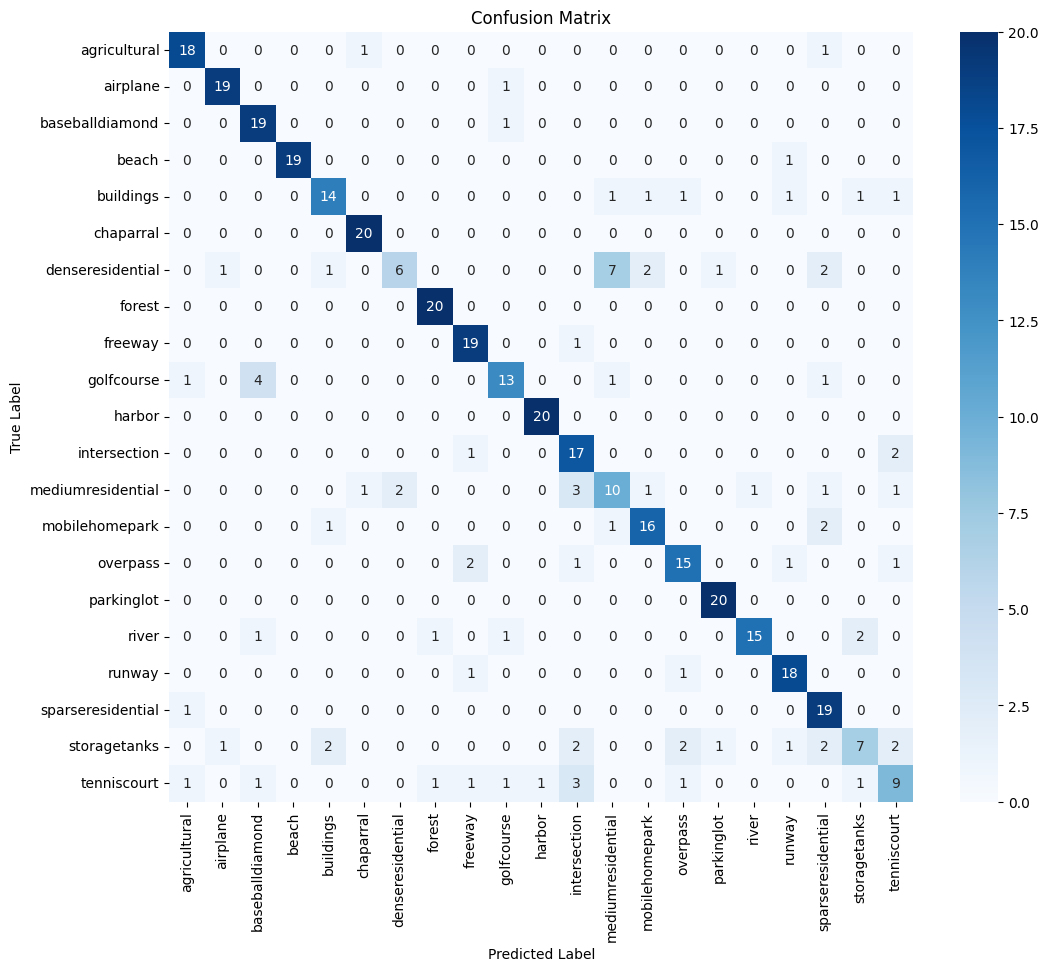

In [9]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with correct class labels
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [10]:
# Save testing metrics and confusion matrix to Excel
df_metrics = pd.DataFrame(
    {
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "MCC"],
        "Value": [accuracy, precision, recall, f1, mcc],
    }
)
with pd.ExcelWriter(f"{student_name}-{reg_number}-testing_metrics.xlsx") as writer:
    df_metrics.to_excel(writer, sheet_name="Metrics", index=False)
    pd.DataFrame(cm).to_excel(writer, sheet_name="Confusion_Matrix", index=False)

## ROC Curve and AUC

In [11]:
# Binarize labels for one-vs-rest ROC
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# Obtain prediction probabilities for all test images
y_score = []

# Reset generator to start from the beginning
test_generator.reset()

# Get total number of batches
total_test_batches = len(test_generator)

for _ in range(total_test_batches):  # Iterate over batches
    x, _ = next(test_generator)  # Use next() instead of .next()
    prob = test_model.predict(x, verbose=0)  # Get probability predictions
    y_score.extend(prob)  # Append all batch predictions

y_score = np.array(y_score)  # Convert list to numpy array


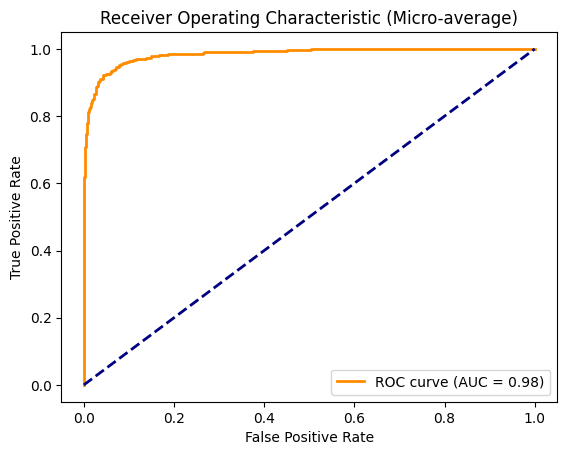

In [12]:
# Compute micro-average ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (Micro-average)")
plt.legend(loc="lower right")
roc_filename = f"{student_name}-{reg_number}-rocgraph.jpeg"
plt.savefig(roc_filename)
plt.show()

## Testing Time Metrics

In [13]:
avg_test_time = np.mean(test_time_list)
print(f"\nAverage testing time per image: {avg_test_time:.4f} seconds")

df_test_time = pd.DataFrame(
    {
        "Image_Index": np.arange(1, test_generator.samples + 1),
        "Testing_Time_sec": test_time_list,
    }
)
df_test_time.to_excel(f"{student_name}-{reg_number}-testingtime.xlsx", index=False)



Average testing time per image: 0.0648 seconds
